In [1]:
import torch

from src.data.project4.dataloader import get_loaders 
from src.models.project4.models import get_model
from src.utils import set_seed, get_optimizer
from src.models.project4.losses import get_loss

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

from omegaconf import OmegaConf

In [2]:
torch.cuda.is_available()

True

In [3]:
args = OmegaConf.create({
    'model_name': 'resnet18',
    'region_size': 224,
    'batch_size': 1,
    'optimizer': 'Adam',
    'loss': 'CE',
    'data_path': '/work3/s194253/02514/project4_results/data_wastedetection',
    'use_super_categories': True,
    'lr': 1e-04,
    'out': False,
    'seed': 0,
    'verbose': False,
    'percentage_to_freeze': None,
})

device = torch.device('cuda:0')
device = torch.device('cpu')

In [4]:
set_seed(args.seed)

In [5]:
# Get data loaders with applied transformations
loaders, num_classes = get_loaders(
    dataset='waste', 
    batch_size=args.batch_size, 
    seed=args.seed, 
    num_workers=1,
    img_size = (512, 512),
    region_size = (args.region_size, args.region_size),
    use_super_categories=args.use_super_categories,
    root = args.data_path,
)

id2cat = loaders['train'].dataset.id2cat

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [6]:
loss_fun = get_loss(args.loss)
optimizer = get_optimizer(args.optimizer)
model = get_model(args.model_name, args, loss_fun, optimizer, out=args.out, num_classes=num_classes, region_size=(args.region_size, args.region_size), id2cat=loaders['train'].dataset.id2cat)

In [10]:
BASE_PATH = '/work3/s194253/02514/project4_results/logs/albertkjoller_efficientnet_crossentropy_resnet/resnet18/albertkjoller_efficientnet_crossentropy_resnet/resnet18/'


VERSION = 0
EPOCH_NAME = 'epoch=9_loss_val=0.3782.ckpt'

checkpoint_path = BASE_PATH + f'version_{VERSION}/checkpoints/' + EPOCH_NAME

model = model.load_from_checkpoint(checkpoint_path, loss_fun=loss_fun)
model.to(device)

model.eval()

print("Checkpoint loaded!")

Checkpoint loaded!


In [11]:
from src.utils import plot_SS
from torchvision.ops import box_iou, nms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics.classification import MulticlassRecall
mc_recall = MulticlassRecall(num_classes=num_classes)


In [12]:
indices_numbered = torch.arange(len(pred_cat))


NameError: name 'pred_cat' is not defined

In [13]:
idxs = """
  0: Can
  1: Carton
  2: Plastic glooves
  3: Aluminium foil
  4: Plastic container
  5: Lid
  6: Shoe
  7: Pop tab
  8: Food waste
  9: Bottle cap
  10: Broken glass
  11: Glass jar
  12: Battery
  13: Cup
  14: Squeezable tube
  15: Unlabeled litter
  16: Plastic utensils
  17: Styrofoam piece
  18: Straw
  19: Plastic bag & wrapper
  20: Blister pack
  21: Paper bag
  22: Paper
  23: Scrap metal
  24: Other plastic
  25: Bottle
  26: Cigarette
  27: Rope & strings
  28: Background"""

id2cat_ss = {int(line.split(': ')[0]): line.split(': ')[-1] for line in idxs.split('\n')[1:]}

In [14]:
inv_id2cat = {v: k for k, v in id2cat.items()}
converter = [0]*len(id2cat)

In [15]:
# creating converter
for id_, cat in id2cat_ss.items():
    converter[id_] = inv_id2cat[cat]

In [16]:
batch_idx = 1
batch = loaders['test'].dataset.__getitem__(batch_idx)

# getting associated target labels
# stage one
recalls = 0
iou_with_nmss = 0
# stage two
acc_bks = 0
acc_no_bks = 0
mc_recall_bks =0
mc_recall_no_bks = 0
# both
mAPs = 0


no_matching_bbox = 0
y_true = []
y_pred = []
n_found_bboxes = []
n_found_bboxes_nms = []

for batch in tqdm(loaders['test']):
    # for each image
    i = 0
    (img, cat_ids, bboxes_data, pred_bboxes_data) = batch[0]

    # for each bounding box
    (bboxes, regions)           = bboxes_data # - not available at this point
    (pred_bboxes, pred_regions) = pred_bboxes_data

    # Classify proposed regions
    y_hat = model.forward(pred_regions.to(device))

    # maximum probabilities
    outputs = torch.nn.functional.softmax(y_hat, dim=1)
    pred_prob, pred_cat = torch.max(outputs, 1)
    pred_cat = torch.tensor(converter)[pred_cat]
    #print("pred_cat:", pred_cat)

    # # Applying NMS (remove redundant boxes)
    keep_indices = []
    indices_numbered = torch.arange(len(pred_cat))
    for cat in pred_cat.unique():
        to_keep = nms(pred_bboxes[pred_cat == cat].to(torch.float).to(device), pred_prob[pred_cat == cat], 0.5).to(device)

        keep_indices += indices_numbered[pred_cat == cat][to_keep]

    keep_indices = torch.tensor(keep_indices)

    # update all
    (pred_bboxes, pred_regions) = (pred_bboxes[keep_indices], pred_regions[keep_indices])
    pred_prob, pred_cat = pred_prob[keep_indices], pred_cat[keep_indices]

    not_bk_preds = pred_cat.cpu() != num_classes-1#max(model.id2cat.keys())


    # Computing AP (removing background)
    
    preds = [{'boxes': pred_bboxes.cpu()[not_bk_preds], 
            'scores': pred_prob.cpu()[not_bk_preds], 
            'labels': pred_cat.cpu()[not_bk_preds]
             }]

    targets = [{
        'boxes':  bboxes, 
        'labels': cat_ids.flatten()
    }]

    pred_matches, gt_matches, gt_labels, gt_labels_idx = model.compare_boxes(bboxes, cat_ids, pred_bboxes, num_classes)

    # getting associated target labels
    # attach background as last label
    cat_ids_bg = torch.concat((cat_ids.flatten(),torch.tensor([num_classes-1]))).flatten()
    target_labels = torch.tensor([cat_ids_bg[idx] for idx in gt_labels_idx])
    # saving
    y_true.append(pred_cat)
    y_pred.append(gt_labels)
    # metrics:
    have_preds = bool(torch.sum(pred_matches))
    # stage one
    recalls += torch.mean(gt_matches.float())   
    acc_bks += torch.mean((pred_cat.detach().cpu() == gt_labels.detach().cpu()).to(torch.float))
    mc_recall_bks += mc_recall(pred_cat, gt_labels)
    # if no similar bounding box
    if have_preds:
        iou_with_nmss += torch.tensor([box_iou(bbox.view(1,-1), pred_bbox.view(1,-1)) for bbox, pred_bbox in zip(bboxes[gt_labels_idx[gt_labels_idx!=-1]], pred_bboxes[pred_matches])]).mean()

        # stage two
        acc_no_bks += torch.mean((pred_cat[pred_matches].detach().cpu() == gt_labels[pred_matches].detach().cpu()).to(torch.float))
        mc_recall_bks += mc_recall(pred_cat, gt_labels)
        mc_recall_no_bks += mc_recall(pred_cat[pred_matches], gt_labels[pred_matches])

        # both
        mAPs += MeanAveragePrecision()(preds, targets)['map_50']
    else:
        # similar to adding zero
        no_matching_bbox += 1

        
y_pred = torch.concat(y_pred)
y_true = torch.concat(y_true)

count = len(loaders['test'])
# divide
# stage one
recalls /= count
iou_with_nmss /= count
# stage two
acc_bks /= count
acc_no_bks /= count
mc_recall_bks /= count
mc_recall_no_bks /= count
# both
mAPs /= count

100%|█████████████████████████████████| 299/299 [38:15<00:00,  7.68s/it]


In [17]:
performance = {'Bounding-box recall': recalls,
               'Pixel-wise IoU': iou_with_nmss,
               'Accuracy w bg': acc_bks,
               'Accuracy w/o bg': acc_no_bks,
               'Multi-class recall w bg': mc_recall_bks,
               'Multi-class recall w/o bg': mc_recall_no_bks,
               'mAPs': mAPs,
              }

## metrics

In [20]:
import numpy as np

In [21]:
for key, value in performance.items():
    value_round = str(np.around(np.array(value), 4))
    print(f'{value_round}:     {key}')

0.4581:     Bounding-box recall
0.2858:     Pixel-wise IoU
0.9297:     Accuracy w bg
0.2094:     Accuracy w/o bg
0.0716:     Multi-class recall w bg
0.0084:     Multi-class recall w/o bg
0.1716:     mAPs


In [29]:
np.save('y_pred', y_pred)
np.save('y_true', y_pred)

## plotting

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [23]:
labels = list(id2cat.values())
len(labels)

29

In [41]:
cm = confusion_matrix(y_true, y_pred, labels=list(id2cat.keys()))#, normalize='all')
cm[-1,-1]

20077

In [47]:
len(y_pred)/len(loaders['test'])

71.85953177257525

20077


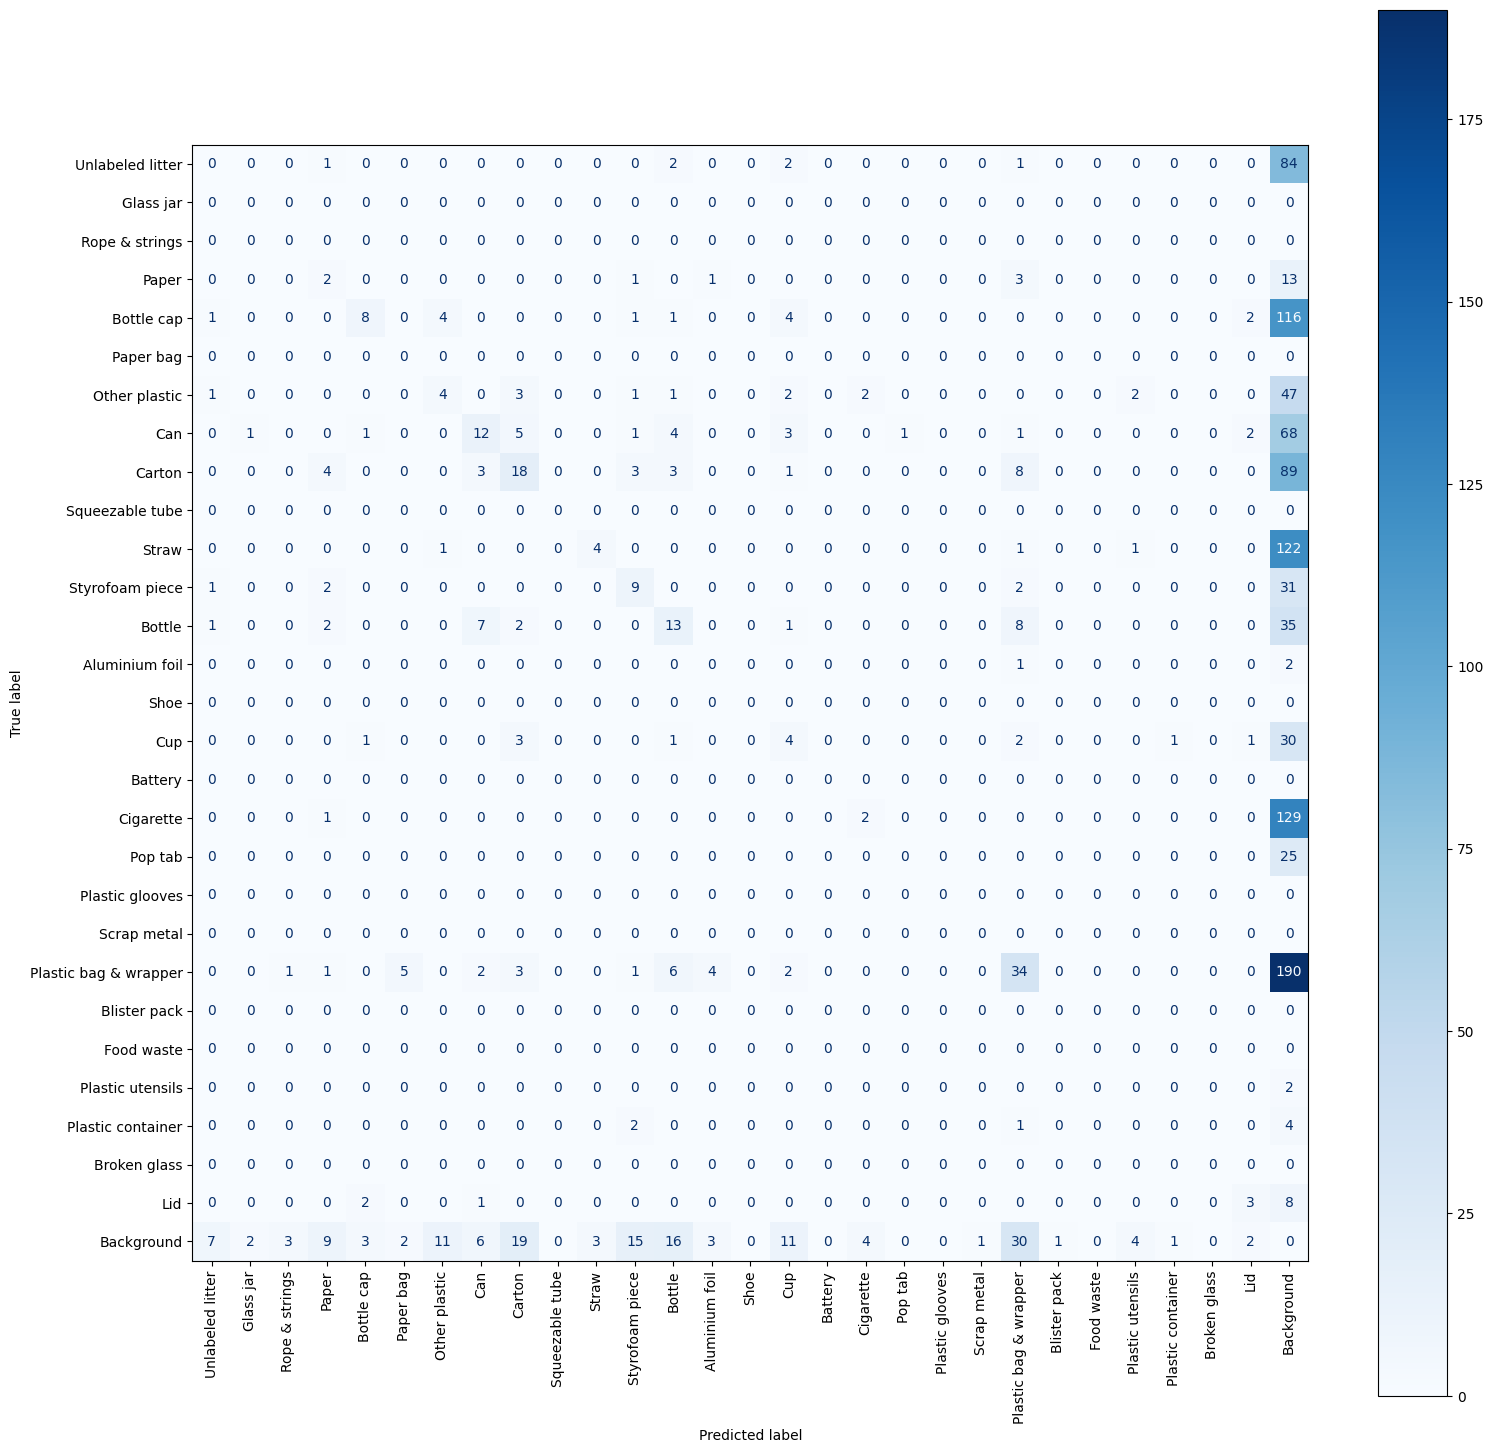

In [46]:
def conf_mat(preds, targets, classes):
    fig, ax = plt.subplots(1, figsize=(18, 18))
    cm = confusion_matrix(targets, preds, labels=list(classes.keys()))#, normalize='all')
    bk = cm[-1,-1]
    cm[-1,-1] = 0
    print(bk)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=classes.values())
    disp.plot(xticks_rotation=90.0, ax=ax, values_format='d', cmap='Blues')
    #plt.show()
    plt.savefig(f'conf_mat.png', dpi=300, bbox_inches='tight')

conf_mat(y_pred, y_true, id2cat)

In [25]:
plt.show()

<BarContainer object of 6 artists>

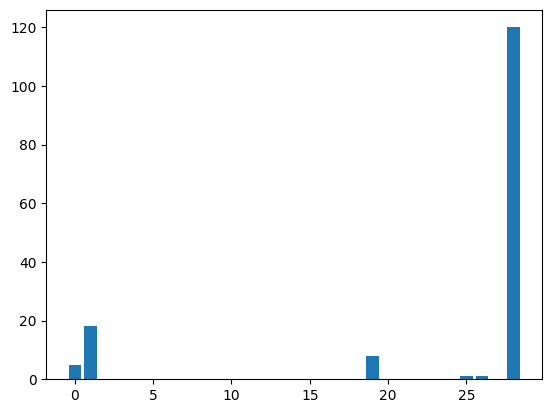

In [40]:
from collections import Counter
w = Counter(pred_cat.numpy())
plt.bar(w.keys(), w.values())